# Demo a Single Simulation Run

In this notebook, we demonstrate a single run of our risk simulation:
- We show the logs of agent actions (e.g. liquidations, arbitrages, peg keeper updates).
- We show a timeseries view of the metrics we collect on agents and the crvusd contracts.
- We plot and analyze results

### Some current limitations
- We are only modeling a single LLAMMA. We are working to incorporate all LLAMMAs to consider hollistic systemic risk.
- We are not considering some key Curve pools yet. For example, we are not explicitly modeling the TriCrypto-ng pools that feed into LLAMMA's oracle.

In [31]:
from copy import deepcopy
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from src.sim.scenario import Scenario
from src.sim.processing import SingleSimProcessor
from src.metrics import DEFAULT_METRICS
from src.logging import get_logger

logger = get_logger(__name__)

pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# Generate markets and prices
market_name = "wstETH"
scenario = Scenario("baseline_macro", market_name)
print(
    f"Running {scenario.num_steps} steps with frequency {scenario.pricepaths.config['freq']}."
)

[INFO][00:08:14][src.sim.scenario]-47573: Fetching sim_market from subgraph.
[INFO][00:08:17][src.sim.scenario]-47573: Market snapshot as 2024-01-07 22:00:47
[INFO][00:08:17][src.sim.scenario]-47573: Bands snapshot as 2024-01-07 19:00:47
[INFO][00:08:17][src.sim.scenario]-47573: Users snapshot as 2024-01-07 23:04:47
[INFO][00:08:25][src.sim.scenario]-47573: Using 245600 1Inch quotes from 2023-11-19 19:00:00 to 2023-12-19 19:00:00
[INFO][00:08:25][src.utils.poolgraph]-47573: Found 20 valid trading cycles of length 3.


Running 365 steps with frequency 1d.


In [40]:
scenario.prepare_for_run()

[INFO][00:08:25][src.sim.scenario]-47573: Equilibrated prices with 1 arbitrages with total profit 411
[INFO][00:08:25][src.sim.scenario]-47573: 3 users were loaded underwater.
[INFO][00:08:25][src.sim.scenario]-47573: Liquidating 0x7d975ea4dedf99944bb6ce8b6aa46efb34a249c2: with debt 11532789225104235772122.
[INFO][00:08:25][src.sim.scenario]-47573: Liquidating 0x653aed4503e3a3f060c744fe85dc780ce549d3c3: with debt 45759123162353166196600.
[INFO][00:08:25][src.sim.scenario]-47573: Liquidating 0x6294371aacbc4b87481ff955a994e37717db6c4d: with debt 12378073238508076898374.
[INFO][00:08:25][src.sim.scenario]-47573: 0.20% of debt was incorrectly loaded with sub-zero health (69669 crvUSD)


In [41]:
processor = SingleSimProcessor(scenario, DEFAULT_METRICS)
processor.initial_state

{'timestamp': Timestamp('2024-01-08 05:08:17'),
 'Bad Debt': 0.0,
 'System Health': 0.47189671122972,
 'Borrower Loss': 0.0,
 'Hard Liquidation Losses': 0,
 'Soft Liquidation Losses': 0.0,
 'Value Leakage': 0.0,
 'Keeper Profit': 0.0,
 'Keeper Count': 0,
 'Liquidator Profit': 0.0,
 'Liquidator Count': 0,
 'Arbitrageur Profit': 0.0,
 'Arbitrageur Count': 0,
 'Peg Strength': 0.9997999506294127,
 'stableswap_crvUSD_TUSD Price': 1.0016161029497221,
 'stableswap_crvUSD_USDP Price': 0.9997594845181245,
 'stableswap_crvUSD_USDC Price': 1.000033058899747,
 'stableswap_crvUSD_USDT Price': 0.9994523214876561,
 'Collateral Liquidated': 0,
 'Debt Repaid': 0,
 'Liquidation Count': 0,
 'pk_crvUSD/TUSD Debt': 0.0,
 'pk_crvUSD/USDP Debt': 0.0,
 'pk_crvUSD/USDC Debt': 2350866.1423239876,
 'pk_crvUSD/USDT Debt': 0.0,
 'PK Debt': 2350866.1423239876,
 'crvUSD Total Supply': 229421525.4088678,
 'llamma_wstETH Price': 2508.0002934383556,
 'llamma_wstETH Oracle Price': 2525.068112890909}

Text(0.5, 1.0, 'wstETH Loan Distribution')

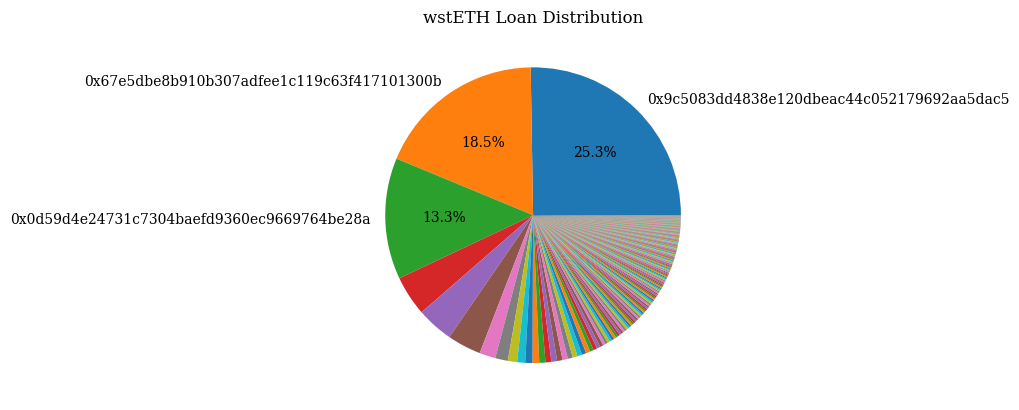

In [5]:
def custom_autopct(pct):
    return "{:.1f}%".format(pct) if pct > 5 else ""


controller = scenario.controller
total_debt = 0
loans = {}
for user, loan in controller.loan.items():
    debt = loan.initial_debt / 1e18
    loans[user] = debt
    total_debt += debt

thresh = 0.05 * total_debt
loans = dict(sorted(loans.items(), key=lambda x: x[1], reverse=True))
labels = [a if loans[a] > thresh else "" for a in loans.keys()]
f, ax = plt.subplots()
pie = ax.pie(loans.values(), labels=labels, autopct=custom_autopct)
ax.set_title(f"{scenario.market_name} Loan Distribution")

### Run the Sim

In [6]:
import cProfile
import pstats

with cProfile.Profile() as pr:
    for sample in scenario.pricepaths:
        scenario.prepare_for_trades(sample)  # update prices/timestamps
        scenario.perform_actions(sample)  # arbitrage, liquidate, update
        processor.update(sample.timestamp, inplace=True)  # collect metrics

stats = pstats.Stats(pr)
stats.sort_stats(pstats.SortKey.CUMULATIVE)
stats.print_stats()

         45250255 function calls (45209140 primitive calls) in 21.046 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      168    0.001    0.000   18.556    0.110 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/sim/scenario.py:287(perform_actions)
      168    0.002    0.000   16.508    0.098 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/agents/arbitrageur.py:35(arbitrage)
      581    0.022    0.000   16.462    0.028 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/agents/arbitrageur.py:79(find_best_arbitrage)
    11620    0.023    0.000   16.396    0.001 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/trades/cycle.py:130(optimize)
    10410    0.039    0.000   14.849    0.001 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/trades/cycle.py:262(_optimize_mem)
    10410    0.058    0.000   14.634    0.001 /Users/tncintra/Deskto

In [7]:
results = processor.process()

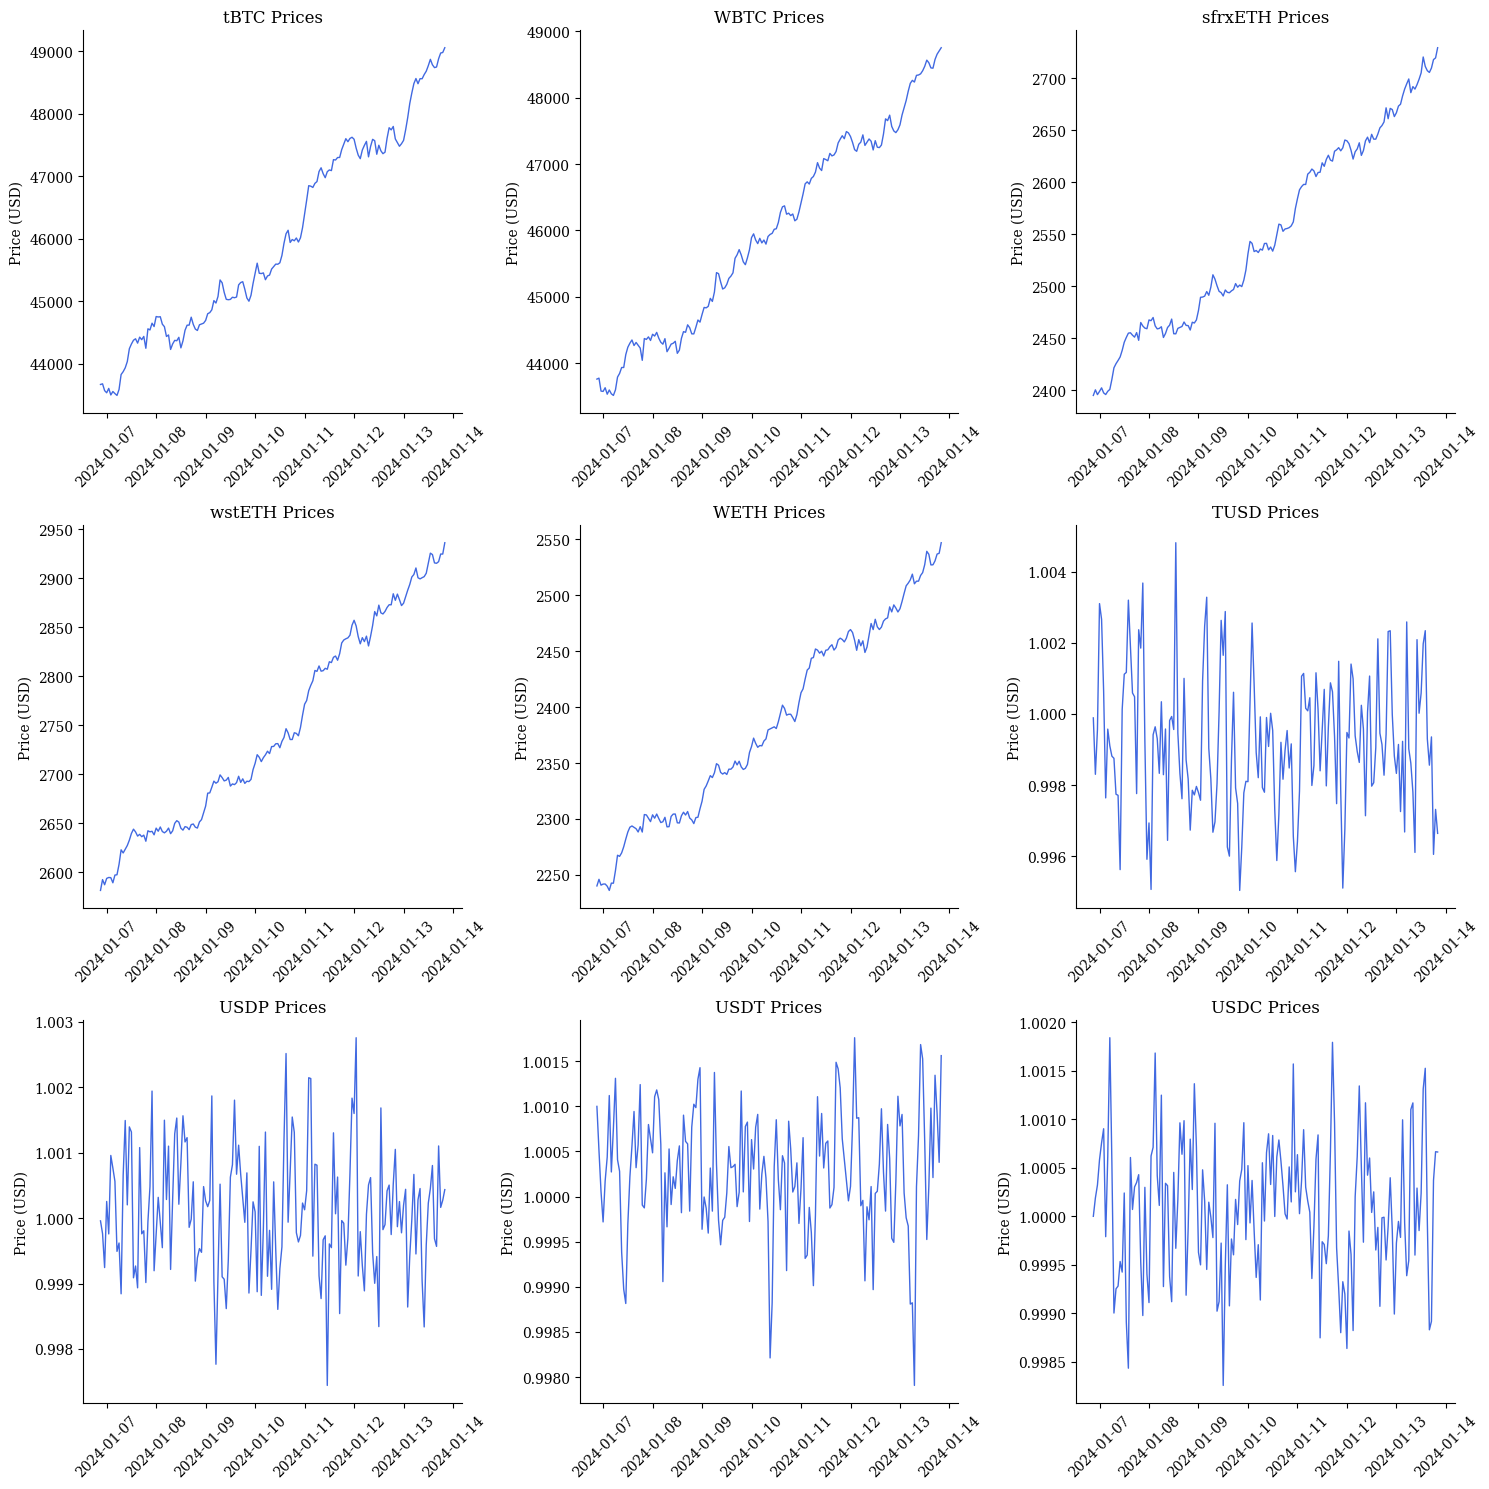

In [8]:
results.plot_prices()

In [9]:
df = results.df
# df.to_csv("../data/results.csv")
df.tail()

,Bad Debt,System Health,Borrower Loss,Hard Liquidation Losses,Soft Liquidation Losses,Value Leakage,Keeper Profit,Keeper Count,Liquidator Profit,Liquidator Count,Arbitrageur Profit,Arbitrageur Count,Peg Strength,stableswap_crvUSD_TUSD Price,stableswap_crvUSD_USDP Price,stableswap_crvUSD_USDC Price,stableswap_crvUSD_USDT Price,Collateral Liquidated,Debt Repaid,Count,PK Debt,pk_crvUSD/TUSD Debt,pk_crvUSD/USDP Debt,pk_crvUSD/USDC Debt,pk_crvUSD/USDT Debt
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-13 15:59:34,0.0,0.721964,1504.902813,0,1504.902813,142669.953579,128.877146,20,0.0,0,142541.076433,402,0.999918,1.000384,1.000196,1.000286,0.999298,0,0,0,2.350866e+06,0.000000,0.0,2.350866e+06,0.0
2024-01-13 16:59:34,0.0,0.722124,1504.902813,0,1504.902813,143697.785586,128.877146,20,0.0,0,143568.908440,404,0.999961,1.000384,0.999278,1.000801,0.998682,0,0,0,2.350866e+06,0.000000,0.0,2.350866e+06,0.0
2024-01-13 17:59:34,0.0,0.726145,1504.902813,0,1504.902813,146298.711100,262.949326,21,0.0,0,146035.761775,407,1.000137,1.001920,0.999683,1.000174,0.999217,0,0,0,2.777695e+06,426828.911851,0.0,2.350866e+06,0.0
2024-01-13 18:59:34,0.0,0.725853,1504.902813,0,1504.902813,146888.173141,262.949326,21,0.0,0,146625.223815,410,0.999756,1.002230,0.999683,0.999782,0.999697,0,0,0,2.777695e+06,426828.911851,0.0,2.350866e+06,0.0
2024-01-13 19:59:34,0.0,0.732008,1504.902813,0,1504.902813,147193.409076,262.949326,21,0.0,0,146930.459750,413,0.999801,1.003593,0.999763,0.999936,0.999422,0,0,0,2.777695e+06,426828.911851,0.0,2.350866e+06,0.0


In [10]:
results.metric_map

{'BadDebtMetric': 0,
 'SystemHealthMetric': 1,
 'BorrowerLossMetric': 2,
 'ValueLeakageMetric': 3,
 'PegStrengthMetric': 4,
 'LiquidationsMetric': 5,
 'PegKeeperMetric': 6}

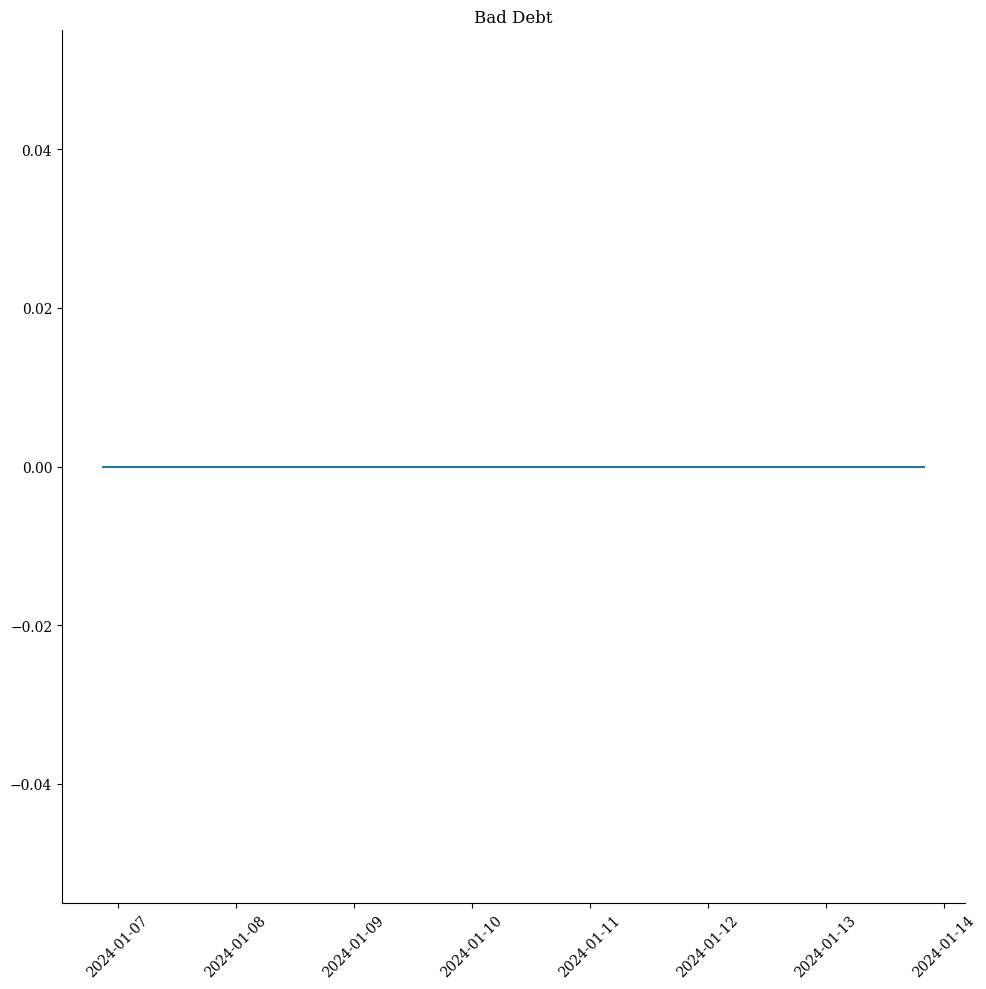

<Axes: title={'center': 'Bad Debt'}>

In [11]:
results.plot_metric(0, show=True)

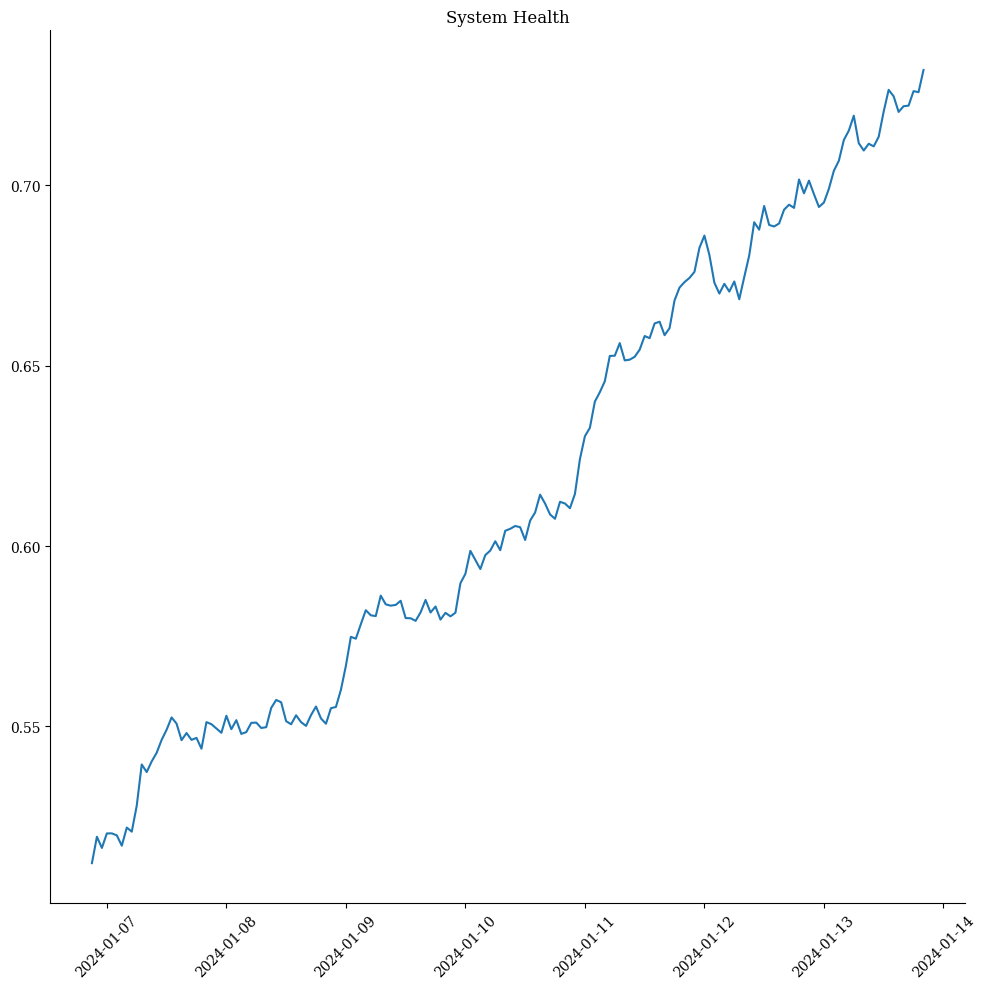

<Axes: title={'center': 'System Health'}>

In [12]:
results.plot_metric(1, show=True)

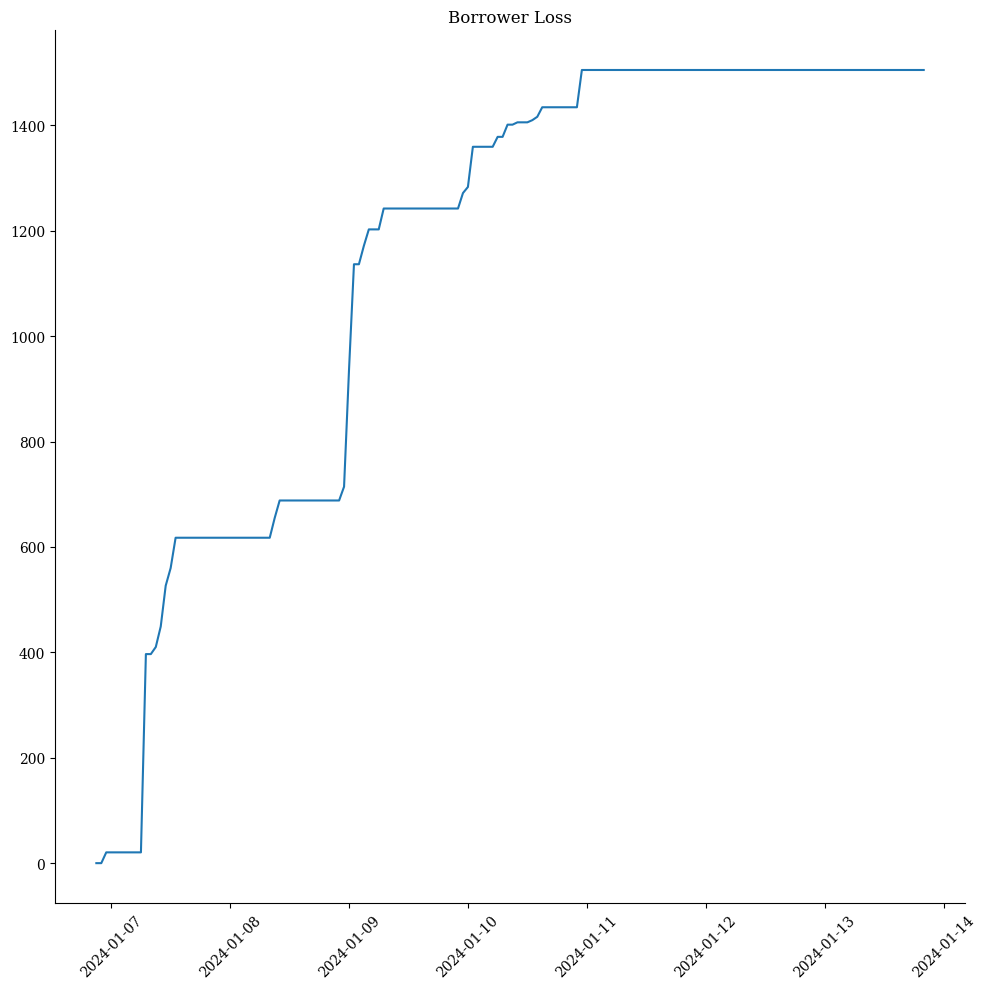

<Axes: title={'center': 'Borrower Loss'}>

In [13]:
results.plot_metric(2, show=True)

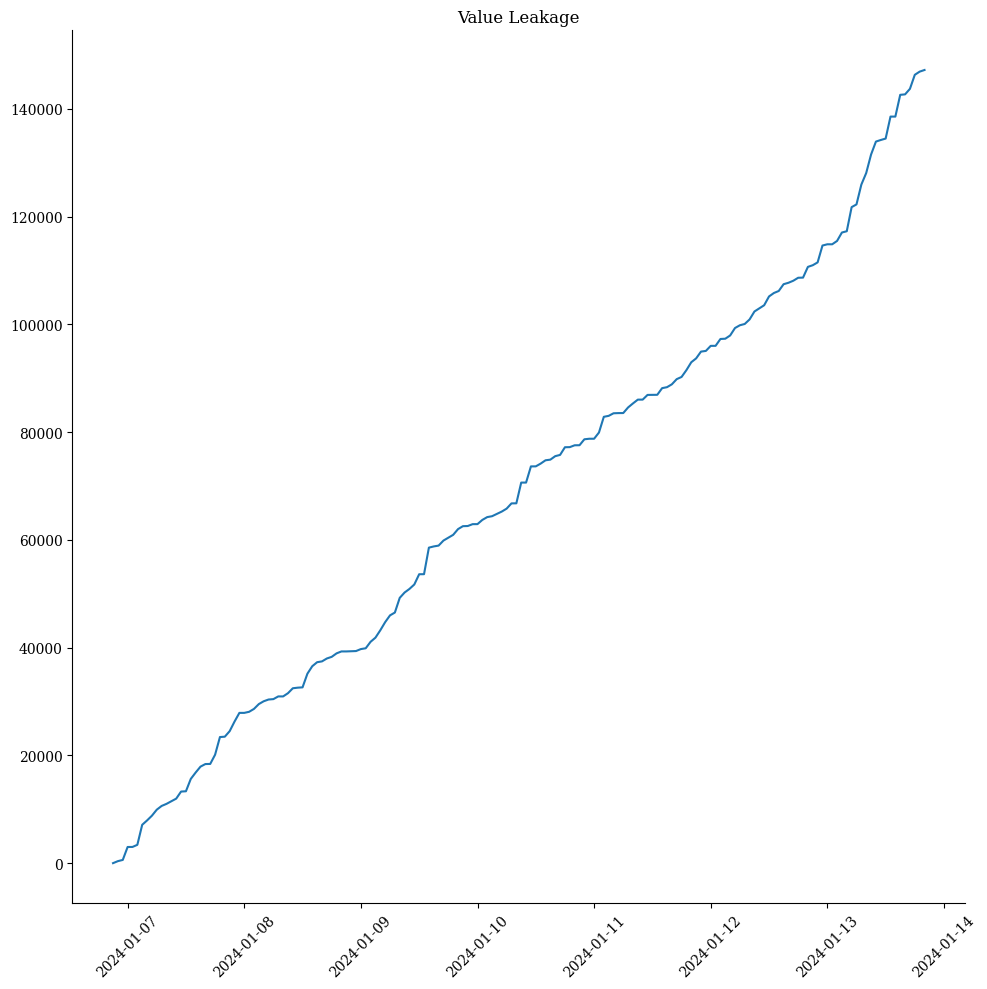

<Axes: title={'center': 'Value Leakage'}>

In [14]:
results.plot_metric(3, show=True)  # seems broken from crvusdsim

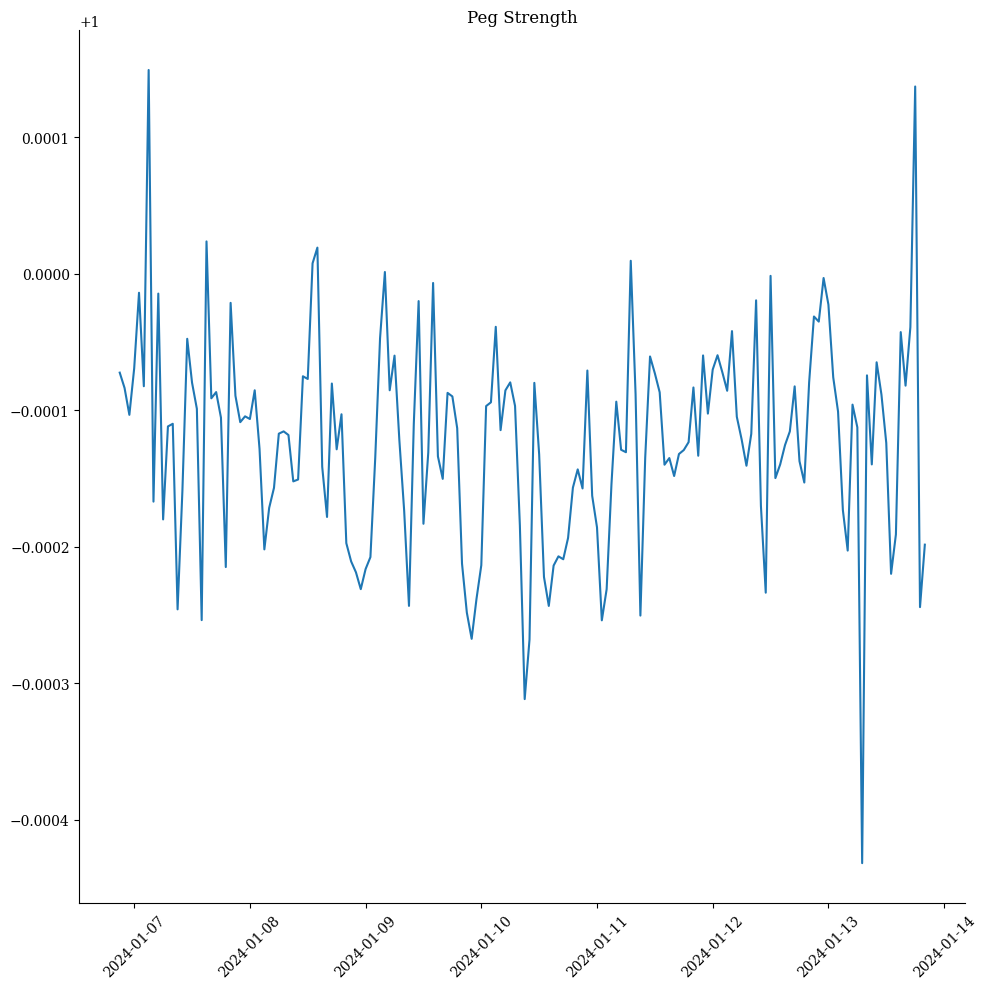

<Axes: title={'center': 'Peg Strength'}>

In [15]:
results.plot_metric(4, show=True)

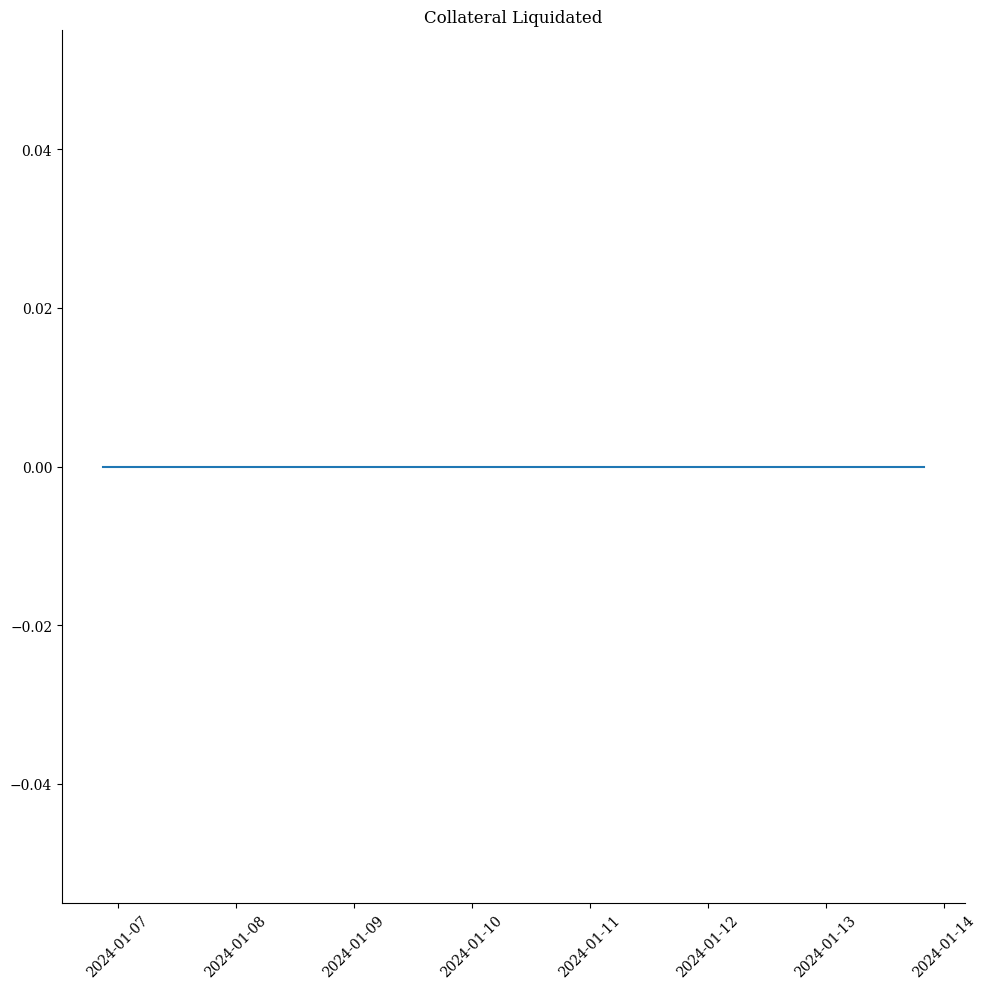

<Axes: title={'center': 'Collateral Liquidated'}>

In [16]:
results.plot_metric(5, show=True)

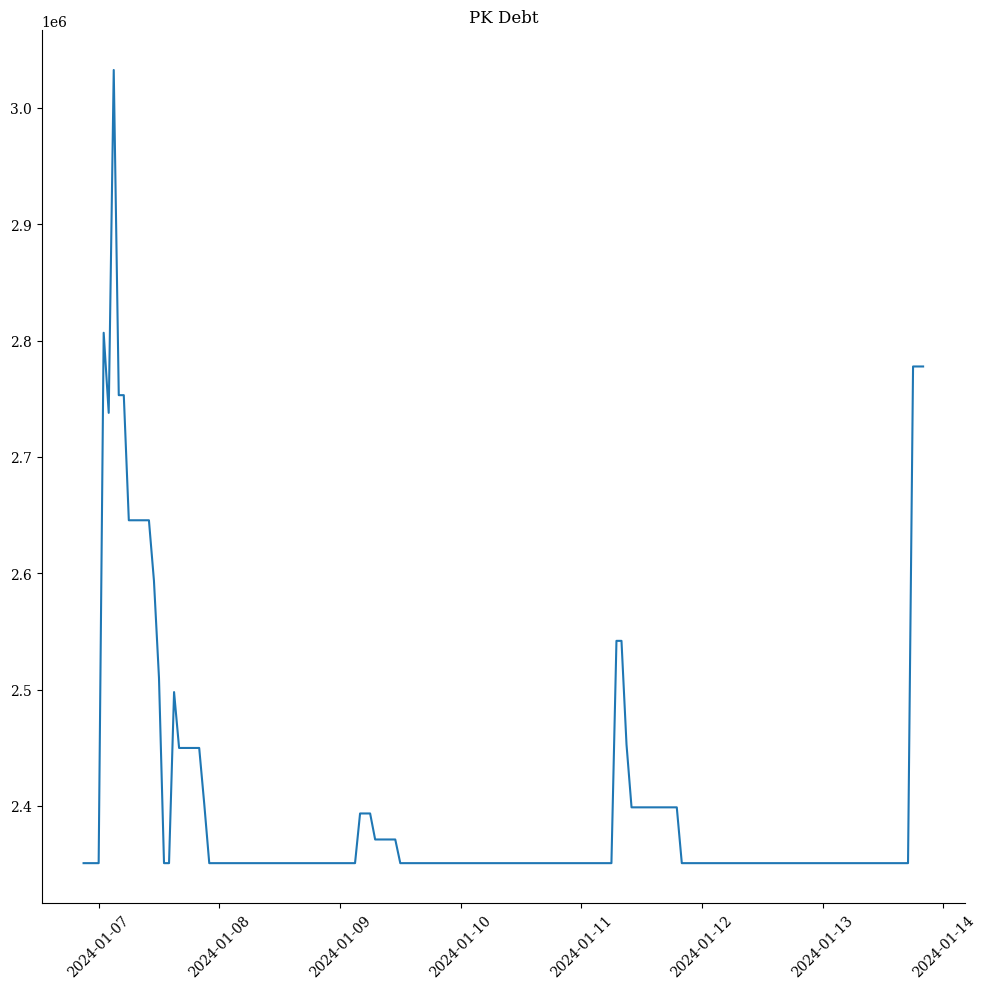

<Axes: title={'center': 'PK Debt'}>

In [17]:
results.plot_metric(6, show=True)

In [18]:
summary = results.summary.T
summary.columns = ["value"]
summary

,value
Bad Debt_max,0.000000e+00
Bad Debt_mean,0.000000e+00
System Health_mean,6.159618e-01
System Health_min,5.121012e-01
Borrower Loss_max,1.504903e+03
Hard Liquidation Losses_max,0.000000e+00
Soft Liquidation Losses_max,1.504903e+03
Value Leakage_max,1.471934e+05
Keeper Profit_max,2.629493e+02
Keeper Count_max,2.100000e+01


In [19]:
df.columns

Index(['Bad Debt', 'System Health', 'Borrower Loss', 'Hard Liquidation Losses',
       'Soft Liquidation Losses', 'Value Leakage', 'Keeper Profit',
       'Keeper Count', 'Liquidator Profit', 'Liquidator Count',
       'Arbitrageur Profit', 'Arbitrageur Count', 'Peg Strength',
       'stableswap_crvUSD_TUSD Price', 'stableswap_crvUSD_USDP Price',
       'stableswap_crvUSD_USDC Price', 'stableswap_crvUSD_USDT Price',
       'Collateral Liquidated', 'Debt Repaid', 'Count', 'PK Debt',
       'pk_crvUSD/TUSD Debt', 'pk_crvUSD/USDP Debt', 'pk_crvUSD/USDC Debt',
       'pk_crvUSD/USDT Debt'],
      dtype='object')

{'usd-coin': {'theta': 9999.999999998432,
  'mu': 1.0000400140622707,
  'sigma': 9.713389430376527,
  'type': 'OU'},
 'tether': {'theta': 9999.999999998416,
  'mu': 1.0003137330987226,
  'sigma': 8.246752723099776,
  'type': 'OU'},
 'paxos-standard': {'theta': 9999.999999990927,
  'mu': 1.0000857372937484,
  'sigma': 13.299240300680454,
  'type': 'OU'},
 'true-usd': {'theta': 10000.000000062017,
  'mu': 0.9990257220059477,
  'sigma': 25.466792913404305,
  'type': 'OU'},
 'weth': {'mu': 2.156993632825848,
  'sigma': 0.44679438874135546,
  'type': 'GBM'},
 'wrapped-steth': {'mu': 2.1839991672464345,
  'sigma': 0.4465770684769973,
  'type': 'GBM'},
 'staked-frax-ether': {'mu': 2.191312166850096,
  'sigma': 0.4632331169409089,
  'type': 'GBM'},
 'wrapped-bitcoin': {'mu': 2.716018689689962,
  'sigma': 0.4296191319361327,
  'type': 'GBM'},
 'tbtc': {'mu': 2.664007765235034, 'sigma': 0.4532692566900212, 'type': 'GBM'}}

In [30]:
# foo.update(results.pricepaths.config["curr_prices"])
foo

{'usd-coin': {'theta': 9999.999999998432,
  'mu': 1.0000400140622707,
  'sigma': 9.713389430376527,
  'type': 'OU',
  'start_price': 1.0},
 'tether': {'theta': 9999.999999998416,
  'mu': 1.0003137330987226,
  'sigma': 8.246752723099776,
  'type': 'OU',
  'start_price': 1.001},
 'paxos-standard': {'theta': 9999.999999990927,
  'mu': 1.0000857372937484,
  'sigma': 13.299240300680454,
  'type': 'OU',
  'start_price': 0.999958},
 'true-usd': {'theta': 10000.000000062017,
  'mu': 0.9990257220059477,
  'sigma': 25.466792913404305,
  'type': 'OU',
  'start_price': 0.99989},
 'weth': {'mu': 2.156993632825848,
  'sigma': 0.44679438874135546,
  'type': 'GBM',
  'start_price': 2240.18},
 'wrapped-steth': {'mu': 2.1839991672464345,
  'sigma': 0.4465770684769973,
  'type': 'GBM',
  'start_price': 2581.28},
 'staked-frax-ether': {'mu': 2.191312166850096,
  'sigma': 0.4632331169409089,
  'type': 'GBM',
  'start_price': 2394.91},
 'wrapped-bitcoin': {'mu': 2.716018689689962,
  'sigma': 0.4296191319361